In [61]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random

# Time Series Analysis of Energy Data

Prompt: "Make a dataset containing power output (in megawatts) from a solar farm recorded hourly over a month. Then write a Python script to analyze the time series data. Your script should identify the peak production hours and any anomalous dips in power generation. Also, include a brief explanation of how weather or other external factors might affect these readings."

Skills Tested: Data manipulation, time series analysis, basic understanding of renewable energy systems.

## Create sample data

In [75]:
sample_df = pd.DataFrame(pd.date_range(start='1/1/2023', end='1/31/2023 23:00', freq='H'), columns=['date'])
sample_df.set_index('date', inplace=True)

# Constants
DAYS = 31
HOURS_IN_DAY = 24
MEAN_SUNLIGHT_HOUR = 12  # Assuming peak sunlight at noon
STD_DEV = 3  # Standard deviation in hours, determines how "spread out" the sunlight hours are
SAMPLE_PEAK_POWER = 10 # in MW

power_output = []
for day in range(DAYS):
    # Create a daily profile centered around noon with 3 hours of spread:
    hours = np.arange(HOURS_IN_DAY)
    daily_power_output = norm.pdf(x=hours, loc=MEAN_SUNLIGHT_HOUR, scale=STD_DEV)
    daily_power_output = np.clip(daily_power_output, a_min=0, a_max=None) # Clip values less than 0
    # Normalize by the maximum, multiply by the sample peak power, then randomly multiply by a value between 0.8-1.1 for daily variety
    daily_power_output = daily_power_output / daily_power_output.max() * SAMPLE_PEAK_POWER * random.uniform(0.8,1.1)
    power_output.extend(daily_power_output)
    
sample_df["power_output"] = power_output

In [72]:
sample_df

,power_output
date,
2023-01-01 00:00:00,0.003539
2023-01-01 01:00:00,0.012702
2023-01-01 02:00:00,0.040788
2023-01-01 03:00:00,0.117208
2023-01-01 04:00:00,0.301387
...,...
2023-01-31 19:00:00,0.653567
2023-01-31 20:00:00,0.284039
2023-01-31 21:00:00,0.110462


<Axes: title={'center': 'Day 1 of Sample Power Data'}, xlabel='date'>

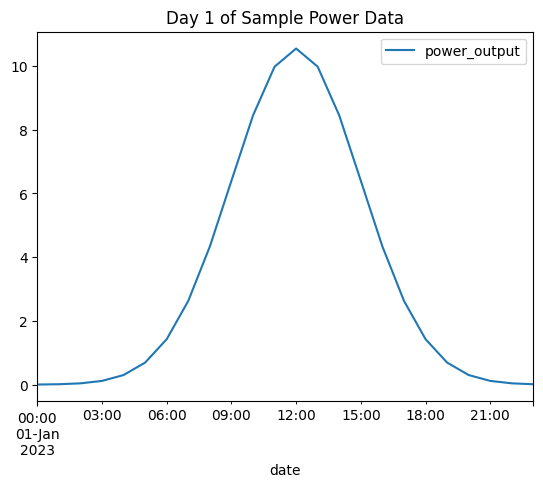

In [73]:
sample_df[0:24].plot(title="Day 1 of Sample Power Data")

<Axes: xlabel='date'>

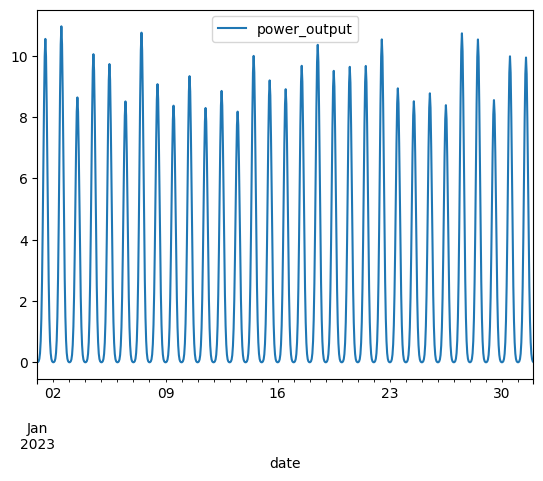

In [74]:
sample_df.plot()

## Identify the peak production hours and any anomalous dips in power generation

In [101]:
# Identify top 10 power output values
top_10_power = sample_df.sort_values(by="power_output", ascending=False)[0:10]
top_10_power

,power_output
date,
2023-01-05 12:00:00,10.895936
2023-01-24 12:00:00,10.750121
2023-01-20 12:00:00,10.540562
2023-01-23 12:00:00,10.538390
2023-01-16 12:00:00,10.477409
2023-01-05 11:00:00,10.307114
2023-01-05 13:00:00,10.307114
2023-01-29 12:00:00,10.307012
2023-01-08 12:00:00,10.305145


In [140]:
print(f"Top 10 power outputs, or 'peak production hours', are from hour {top_10_power.index.hour.min()} to {top_10_power.index.hour.max()}. ")

Top 10 power outputs, or 'peak production hours', are from hour 11 to 13. 


In [139]:
# Identify any anomalous dips in power generation
# First, to find anomalous dips, lets focus on peak hours -- hours 11 to 13 -- and find the 95th percentile
sample_df_peak_hours = sample_df[(sample_df.index.hour>=11)&(sample_df.index.hour<=13)]
min_threshold = sample_df_peak_hours["power_output"].quantile(0.05)

for hour, value in sample_df_peak_hours.iterrows():
    if value["power_output"] < min_threshold:
        print(f"Anomalous dip occurs at {hour} with value {round(value['power_output'],3)}")

Anomalous dip occurs at 2023-01-02 11:00:00 with value 7.589
Anomalous dip occurs at 2023-01-02 13:00:00 with value 7.589
Anomalous dip occurs at 2023-01-27 11:00:00 with value 7.595
Anomalous dip occurs at 2023-01-27 13:00:00 with value 7.595


## Include a brief explanation of how weather or other external factors might affect these readings

Cloudiness, seasonality, and other weather factors can impact the solar power output from the panels. Additionally, there could be either physical or software issues that impact the reading. For example, any shade imposed on the solar panels or any grime/dirt could significantly reduce the power output. There could also be inverter failures. Or simply, the software could be incorrectly reporting the pv power output. 

# Query Simulation for Energy Analytics

Prompt: "Assume you have a database (simulated as a Python dictionary provided below) containing information about various clean energy projects (solar, wind, hydroelectric) across different states. Write a Python script to query this database and find the top 5 states with the highest installed capacity for renewable energy."

Skills Tested: Database querying (simulated through Python), data analysis, knowledge of renewable energy trends.

In [142]:
energy_projects_data = {
    'California': [
        {'project_name': 'Solar Farm A', 'capacity_mw': 120, 'year_started': 2015},
        {'project_name': 'Wind Farm B', 'capacity_mw': 300, 'year_started': 2012},
        {'project_name': 'Hydroelectric C', 'capacity_mw': 50, 'year_started': 2010},
    ],
    'Texas': [
        {'project_name': 'Solar Farm D', 'capacity_mw': 180, 'year_started': 2018},
        {'project_name': 'Wind Farm E', 'capacity_mw': 500, 'year_started': 2011},
        {'project_name': 'Biomass F', 'capacity_mw': 75, 'year_started': 2014},
    ],
    'New York': [
        {'project_name': 'Solar Farm G', 'capacity_mw': 90, 'year_started': 2014},
        {'project_name': 'Wind Farm H', 'capacity_mw': 150, 'year_started': 2019},
        {'project_name': 'Geothermal I', 'capacity_mw': 25, 'year_started': 2016},
    ],
    'Massachusetts': [
        {'project_name': 'Solar Farm J', 'capacity_mw': 30, 'year_started': 2020},
        {'project_name': 'Hydroelectric K', 'capacity_mw': 20, 'year_started': 2009},
    ],
    'Illinois': [
        {'project_name': 'Wind Farm L', 'capacity_mw': 200, 'year_started': 2013},
        {'project_name': 'Solar Farm M', 'capacity_mw': 100, 'year_started': 2016},
    ],
    'Arizona': [
        {'project_name': 'Solar Farm N', 'capacity_mw': 150, 'year_started': 2017},
    ],
    'Florida': [
        {'project_name': 'Solar Farm O', 'capacity_mw': 110, 'year_started': 2015},
        {'project_name': 'Hydroelectric P', 'capacity_mw': 60, 'year_started': 2014},
    ],
    'Oregon': [
        {'project_name': 'Wind Farm Q', 'capacity_mw': 220, 'year_started': 2017},
        {'project_name': 'Hydroelectric R', 'capacity_mw': 180, 'year_started': 2013},
        {'project_name': 'Solar Farm S', 'capacity_mw': 55, 'year_started': 2018},
    ],
    'Washington': [
        {'project_name': 'Hydroelectric T', 'capacity_mw': 300, 'year_started': 2010},
        {'project_name': 'Wind Farm U', 'capacity_mw': 160, 'year_started': 2011},
    ],
    'Colorado': [
        {'project_name': 'Solar Farm V', 'capacity_mw': 130, 'year_started': 2019},
        {'project_name': 'Wind Farm W', 'capacity_mw': 155, 'year_started': 2020},
        {'project_name': 'Biomass X', 'capacity_mw': 45, 'year_started': 2013},
    ]
}

In [242]:
def top_5_states(capacity_dict):
    """ Query the sample dictionary and find the top 5 states with the highest installed capacity for renewable energy
    capacity_dict: a dictionary containing the state name in the first level, and the project name, capacity_mw, and year_started
                    in the second level
    return: dataframe with the top 5 states with highest installed capacity
    """
    top_5_states = pd.DataFrame(data=[
        {'state': state, 'capacity': sum(project['capacity_mw'] for project in projects)} for state, projects in capacity_dict.items()])
    
    
    return top_5_states.sort_values(by='capacity', ascending=False)[0:5]
    

In [243]:
top_5_states(capacity_dict=energy_projects_data)

,state,capacity
1,Texas,755
0,California,470
8,Washington,460
7,Oregon,455
9,Colorado,330


# Simulation of Energy Storage Systems

Prompt: "Create a Python simulation for a battery energy storage system. The simulation should take as input the storage capacity (in MWh), charge/discharge rates (in MW), energy costs, and simulate how the storage system responds to a given load profile over 24 hours. Your script should also calculate the efficiency losses due to charging and discharging and demonstrate how energy storage can aid in load balancing."

Skills Tested: Understanding of energy storage systems, simulation skills, basic physics and engineering principles related to energy efficiency.

<Axes: title={'center': 'Sample Load Data for One Day'}>

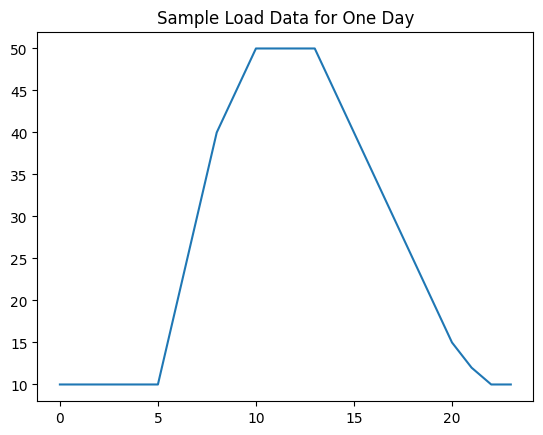

In [252]:
# Sample hourly load profile data in MW
load_data = {
    'hour': range(24),
    'demand_mw': [
        10, 10, 10, 10, 10, 10,  # 00:00 - 05:00 Low demand
        20, 30, 40, 45, 50, 50,  # 06:00 - 11:00 Increasing demand
        50, 50, 45, 40, 35, 30,  # 12:00 - 17:00 High demand
        25, 20, 15, 12, 10, 10   # 18:00 - 23:00 Decreasing demand
    ]
}

# Create a DataFrame
load_profile_df = pd.DataFrame(load_data)

# Display the DataFrame
load_profile_df['demand_mw'].plot(title="Sample Load Data for One Day")

<Axes: title={'center': 'Costs for One Day'}>

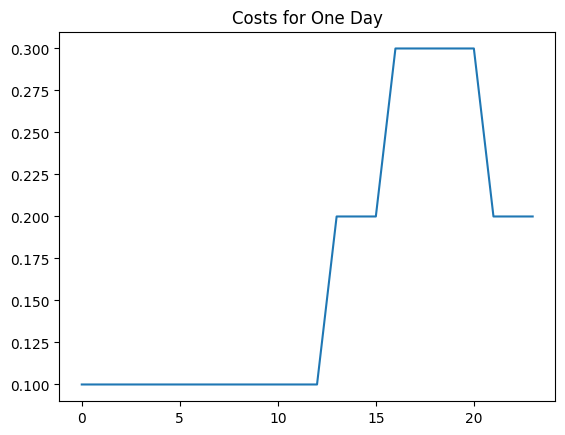

In [257]:
# Sample hourly energy cost data in $/MW
# Highest costs, the "peak period", is from 16:00-21:00 
# The partial peak period is 3 hours before and 3 hours after the peak period
cost_data = {
    'hour': range(24),
    'cost_mw': [
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 00:00 - 05:00 Low cost
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 06:00 - 11:00 Low cost
        0.1, 0.2, 0.2, 0.2, 0.3, 0.3,  # 12:00 - 17:00 Low-Med-High cost
        0.3, 0.3, 0.3, 0.2, 0.2, 0.2   # 18:00 - 23:00 High-Med-Low cost
    ]
}

# Create a DataFrame
cost_profile_df = pd.DataFrame(cost_data)

# Display the DataFrame
cost_profile_df['cost_mw'].plot(title="Costs for One Day")

In [258]:
# Initialize parameters
ESS_CAPACITY = 30 # MWH
ESS_CHARGE_RATE = 15 # MW
ESS_DISCHARGE_RATE = 15 # MW
RTE = 0.88

In [261]:
# Combine load and cost dataframes
load_cost = load_profile_df.copy()
load_cost["cost_mw"] = cost_profile_df['cost_mw']
load_cost.set_index("hour", inplace=True)

load_cost

,demand_mw,cost_mw
hour,,
0,10,0.1
1,10,0.1
2,10,0.1
3,10,0.1
4,10,0.1
5,10,0.1
6,20,0.1
7,30,0.1
8,40,0.1
